In [58]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler



# Data Process
df = pd.read_excel("Caffeine_Sleep.xlsx")
df['Date'] = pd.to_datetime(df['Date'])
df['Deep Sleep Ratio'] = df['Deep Sleep (hrs)'] / df['Total Sleep (hrs)']

df['Date'] = pd.to_datetime(df['Date'])
df['Coffee Time'] = pd.to_datetime(df['Coffee Time'], format="%H:%M", errors='coerce').dt.time
df['Bed Time'] = pd.to_datetime(df['Bed Time'], format='%H:%M', errors='coerce').dt.time

# Numeric data type conversions
df['Caffeine (mg)'] = pd.to_numeric(df['Caffeine (mg)'], errors='coerce')
df['Total Sleep (hrs)'] = pd.to_numeric(df['Total Sleep (hrs)'], errors='coerce')
df['Deep Sleep (hrs)'] = pd.to_numeric(df['Deep Sleep (hrs)'], errors='coerce')
df['Deep Sleep Ratio'] = pd.to_numeric(df['Deep Sleep Ratio'], errors='coerce')
df['Coffee Consumed Numeric'] = df['Coffee Consumed'].map({'Yes': 1, 'No': 0})
df['Coffee Period Numeric'] = df['Coffee Period'].map({
    'Before 15:00': 0,
    'After 15:00': 1
})

# One-hot encode the 'Weather Condition' column
weather_encoded = pd.get_dummies(df['Weather Condition'], prefix="Weather")
weather_encoded = weather_encoded[['Weather_Sunny', 'Weather_Cloudy', 'Weather_Rainy']]
df = pd.concat([df, weather_encoded], axis=1)
df.drop(columns=['Weather Condition'], inplace=True)

df['Coffee Period Numeric'] = df['Coffee Period'].map({
    'Before 15:00': 0,
    'After 15:00': 1
    # 'No Coffee' is automatically mapped to NaN
})


# Processed Data
processed_file_path = "processed_sleep_data.csv"
df.to_csv(processed_file_path, index=False)
print(f"Processed dataset saved to {processed_file_path}")


Processed dataset saved to processed_sleep_data.csv


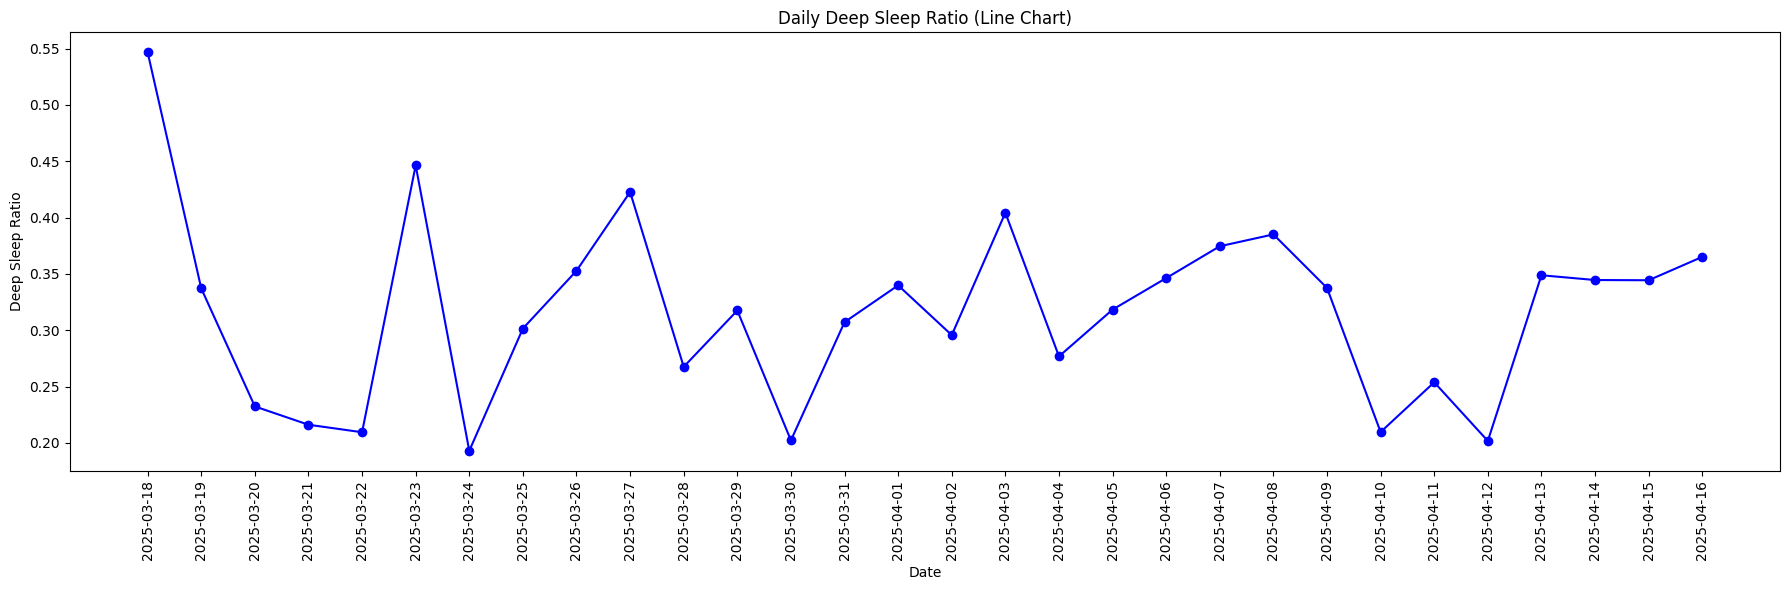

In [59]:
# Line Chart:Daily Deep Sleep Ratio
plt.figure(figsize=(18, 6))
plt.plot(df['Date'].dt.strftime('%Y-%m-%d'), df['Deep Sleep Ratio'], marker='o', linestyle='-', color='blue')
plt.title('Daily Deep Sleep Ratio (Line Chart)')
plt.xlabel('Date')
plt.ylabel('Deep Sleep Ratio')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

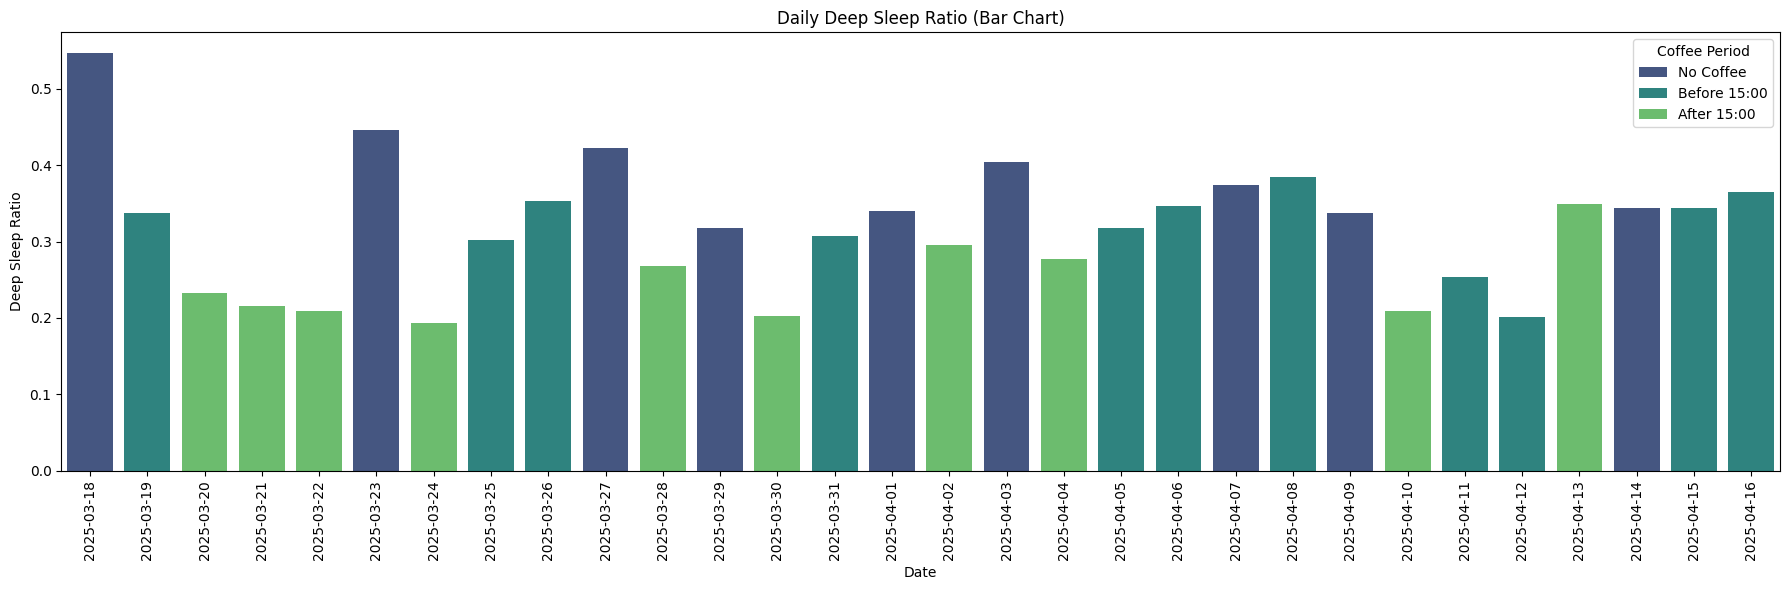

In [60]:
# Bar Chart: Daily Deep Sleep Ratio
plt.figure(figsize=(18, 6))
sns.barplot(x='Date', y='Deep Sleep Ratio', hue='Coffee Period', data=df, palette='viridis')
plt.title('Daily Deep Sleep Ratio (Bar Chart)')
plt.xlabel('Date')
plt.ylabel('Deep Sleep Ratio')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


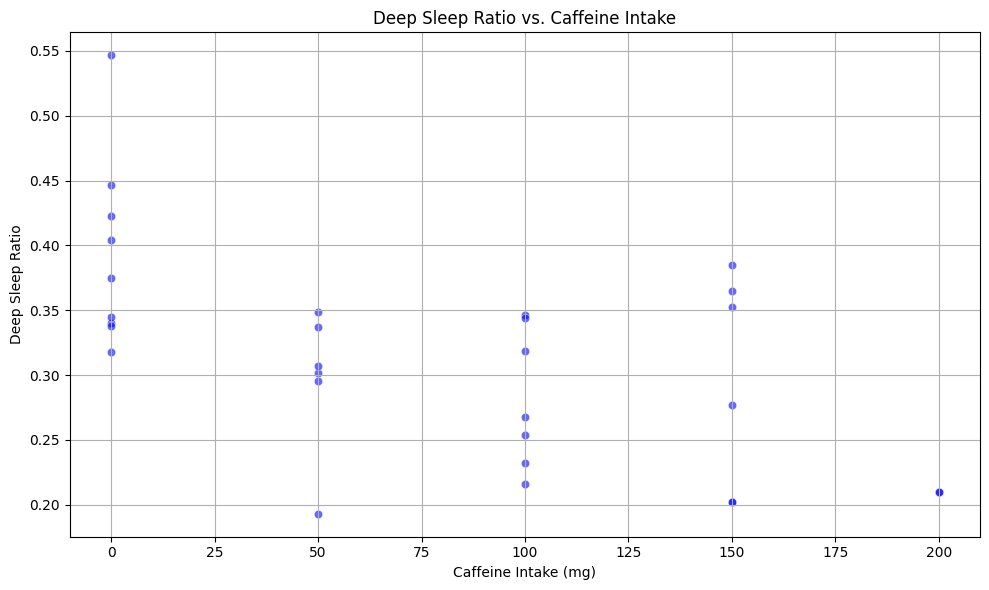

In [49]:
# Scatter plot: Caffeine Intake vs Deep Sleep Ratio
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Caffeine (mg)',
    y='Deep Sleep Ratio',
    data=df,
    alpha=0.6,
    color='blue'
)
plt.title("Deep Sleep Ratio vs. Caffeine Intake")
plt.xlabel("Caffeine Intake (mg)")
plt.ylabel("Deep Sleep Ratio")
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-50-634a6e3c48f6>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Coffee Period', y='Deep Sleep Ratio', data=coffee_data, palette="Set3")


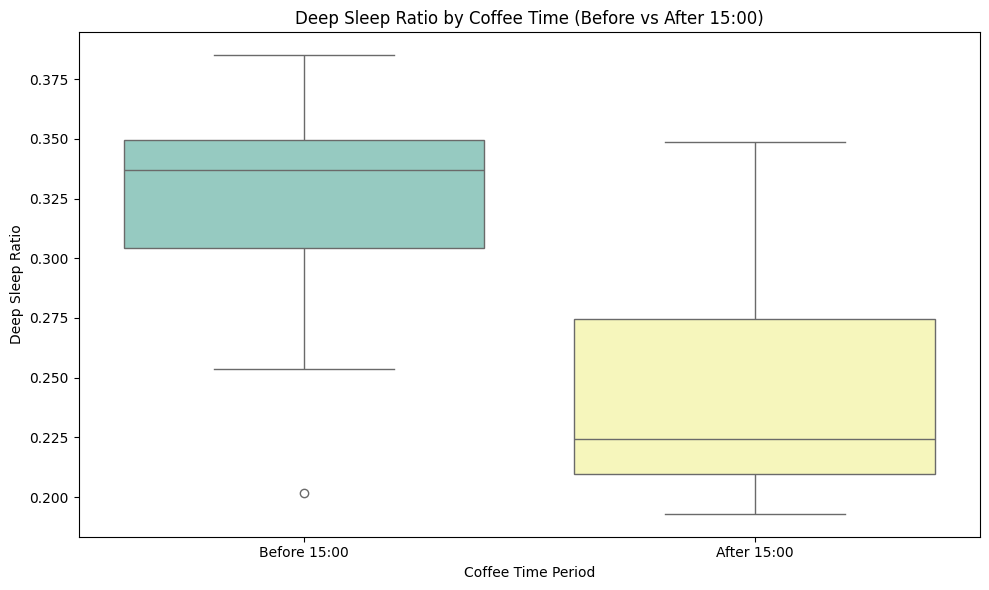

In [50]:
coffee_data = df[df['Coffee Period'].isin(['Before 15:00', 'After 15:00'])]
# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Coffee Period', y='Deep Sleep Ratio', data=coffee_data, palette="Set3")
plt.title("Deep Sleep Ratio by Coffee Time (Before vs After 15:00)")
plt.ylabel("Deep Sleep Ratio")
plt.xlabel("Coffee Time Period")
plt.tight_layout()
plt.show()


<ipython-input-61-7d1ade29b54d>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Coffee Consumed', y='Deep Sleep Ratio', data=df, palette="colorblind")


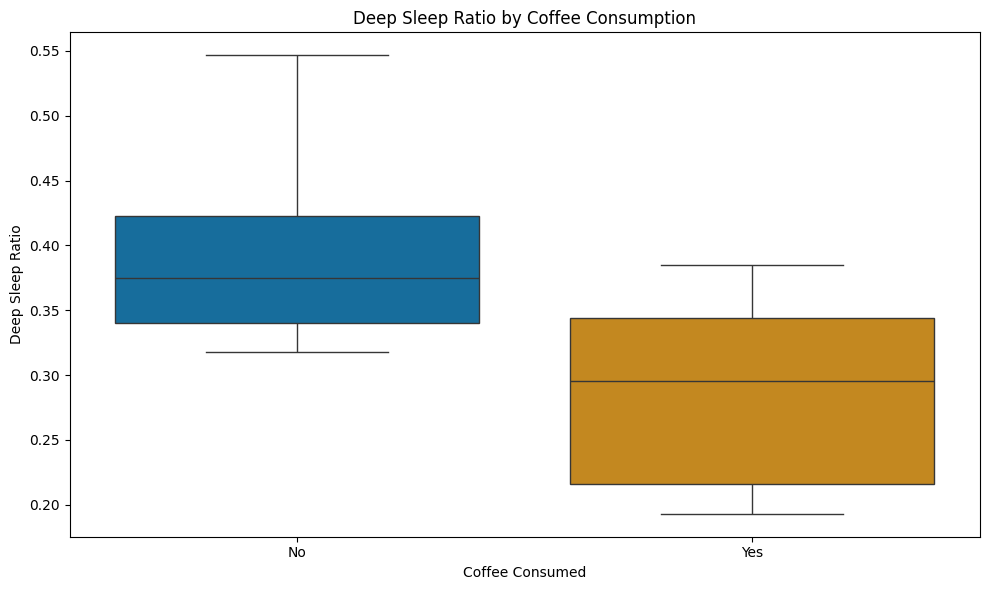

In [61]:
df['Coffee Consumed'] = df['Caffeine (mg)'].apply(lambda x: 'Yes' if x > 0 else 'No')

# Boxplot: Coffee Consumed vs Coffee Not Consumed
plt.figure(figsize=(10, 6))
sns.boxplot(x='Coffee Consumed', y='Deep Sleep Ratio', data=df, palette="colorblind")
plt.title("Deep Sleep Ratio by Coffee Consumption")
plt.ylabel("Deep Sleep Ratio")
plt.xlabel("Coffee Consumed")
plt.tight_layout()
plt.show()

<ipython-input-62-a2b818796c65>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Caffeine Category', y='Deep Sleep Ratio', data=df, palette="Set2")


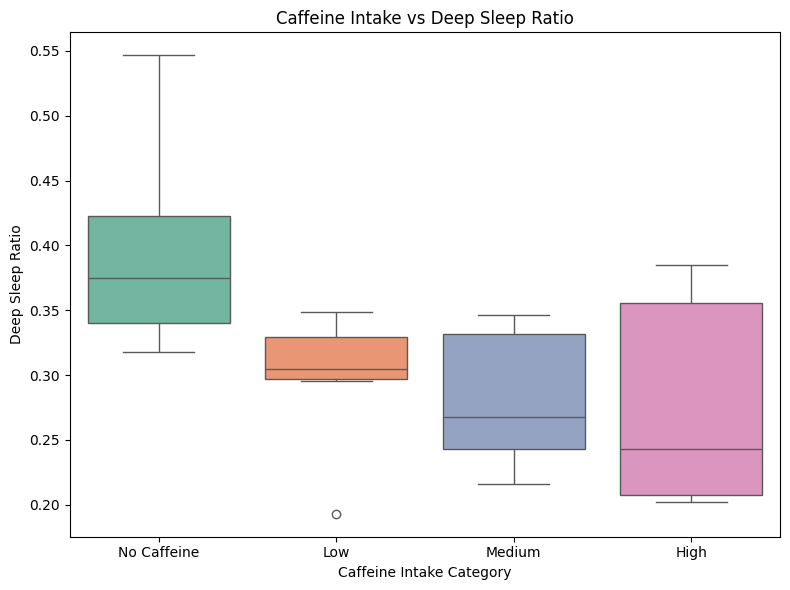

In [62]:
def caffeine_category(mg):
    if mg == 0:
        return 'No Caffeine'
    elif mg <= 50:
        return 'Low'
    elif mg <= 100:
        return 'Medium'
    elif mg <= 200:
        return 'High'

df['Caffeine Category'] = df['Caffeine (mg)'].apply(caffeine_category)

# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Caffeine Category', y='Deep Sleep Ratio', data=df, palette="Set2")
plt.title('Caffeine Intake vs Deep Sleep Ratio')
plt.xlabel('Caffeine Intake Category')
plt.ylabel('Deep Sleep Ratio')
plt.tight_layout()
plt.show()

<ipython-input-53-edcd509dc930>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Weather Category', y='Deep Sleep Ratio', data=df, palette='pastel')


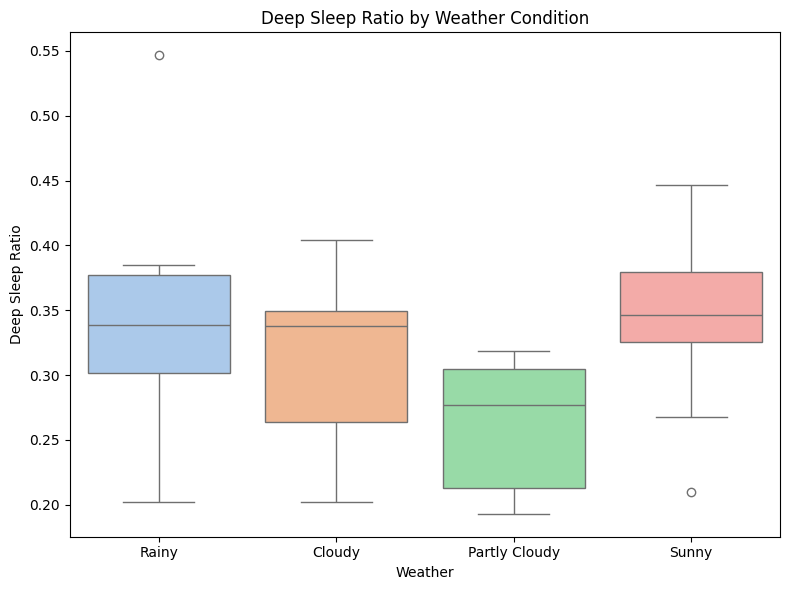

In [53]:
def infer_weather_condition(row):
    if row['Weather_Sunny']:
        return 'Sunny'
    elif row['Weather_Cloudy']:
        return 'Cloudy'
    elif row['Weather_Rainy']:
        return 'Rainy'
    else:
        return 'Partly Cloudy'

df['Weather Category'] = df.apply(infer_weather_condition, axis=1)


plt.figure(figsize=(8, 6))
sns.boxplot(x='Weather Category', y='Deep Sleep Ratio', data=df, palette='pastel')
plt.title("Deep Sleep Ratio by Weather Condition")
plt.xlabel("Weather")
plt.ylabel("Deep Sleep Ratio")
plt.tight_layout()
plt.show()


In [63]:
from scipy.stats import ttest_ind


caffeine_yes = df[df['Coffee Consumed'] == 'Yes']['Deep Sleep Ratio'].dropna()
caffeine_no = df[df['Coffee Consumed'] == 'No']['Deep Sleep Ratio'].dropna()

# t-test
t_stat, p_value = ttest_ind(caffeine_yes, caffeine_no, equal_var=False, alternative='less')

print("Hypothesis: Compare Deep Sleep Ratio for Coffee Consumed vs Not Consumed")
print("Null Hypothesis: Deep Sleep Ratio is the same for both groups.")
print("Alternative Hypothesis: Deep Sleep Ratio is less in Coffee Consumed group.")
print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")
print(f"Reject Null Hypothesis: {p_value < 0.05}")


Hypothesis: Compare Deep Sleep Ratio for Coffee Consumed vs Not Consumed
Null Hypothesis: Deep Sleep Ratio is the same for both groups.
Alternative Hypothesis: Deep Sleep Ratio is less in Coffee Consumed group.
T-Statistic: -3.9160706512591625
P-Value: 0.0008276426405679514
Reject Null Hypothesis: True


In [64]:
from scipy.stats import ttest_ind


time_df = df[df['Coffee Period'].isin(['Before 15:00', 'After 15:00'])]


before_15 = time_df[time_df['Coffee Period'] == 'Before 15:00']['Deep Sleep Ratio'].dropna()
after_15 = time_df[time_df['Coffee Period'] == 'After 15:00']['Deep Sleep Ratio'].dropna()
# t-test

t_stat_time, p_value_time = ttest_ind(after_15, before_15, equal_var=False, alternative='less')

print("Hypothesis: Deep Sleep Ratio for Coffee After 15:00 is lower than Before 15:00")
print("Null Hypothesis: Coffee time does not affect deep sleep.")
print("Alternative Hypothesis: Coffee after 15:00 lowers deep sleep ratio.")
print(f"T-Statistic: {t_stat_time}")
print(f"P-Value: {p_value_time}")
print(f"Reject Null Hypothesis: {p_value_time < 0.05}")


Hypothesis: Deep Sleep Ratio for Coffee After 15:00 is lower than Before 15:00
Null Hypothesis: Coffee time does not affect deep sleep.
Alternative Hypothesis: Coffee after 15:00 lowers deep sleep ratio.
T-Statistic: -3.2960928654772714
P-Value: 0.0019054227153095724
Reject Null Hypothesis: True


In [65]:
from scipy.stats import pearsonr


subset = df[['Caffeine (mg)', 'Deep Sleep Ratio']].dropna()

# Pearson correlation test
correlation_value, p_value_corr = pearsonr(subset['Caffeine (mg)'], subset['Deep Sleep Ratio'])

print("Hypothesis: Higher caffeine intake reduces deep sleep ratio")
print("Null Hypothesis: No relationship between caffeine intake and deep sleep ratio.")
print("Alternative Hypothesis: Higher caffeine intake is associated with lower deep sleep ratio.")
print(f"Pearson Correlation Coefficient: {correlation_value}")
print(f"P-Value: {p_value_corr}")
print(f"Reject Null Hypothesis: {p_value_corr < 0.05}")


Hypothesis: Higher caffeine intake reduces deep sleep ratio
Null Hypothesis: No relationship between caffeine intake and deep sleep ratio.
Alternative Hypothesis: Higher caffeine intake is associated with lower deep sleep ratio.
Pearson Correlation Coefficient: -0.5775094011454257
P-Value: 0.0008328511641658056
Reject Null Hypothesis: True


Linear Regression Results:
 - Mean Squared Error: 0.00519
 - R² Score: -0.16


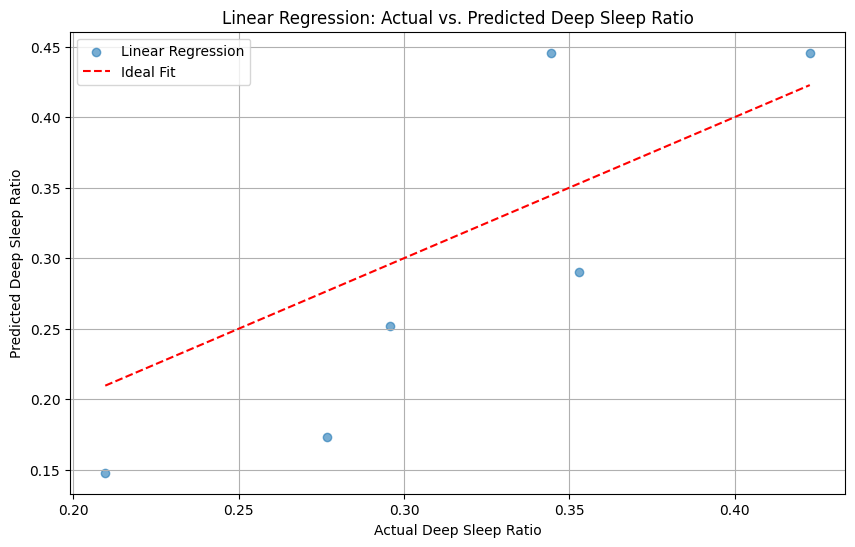

Decision Tree Results:
 - Mean Squared Error: 0.00452
 - R² Score: -0.01


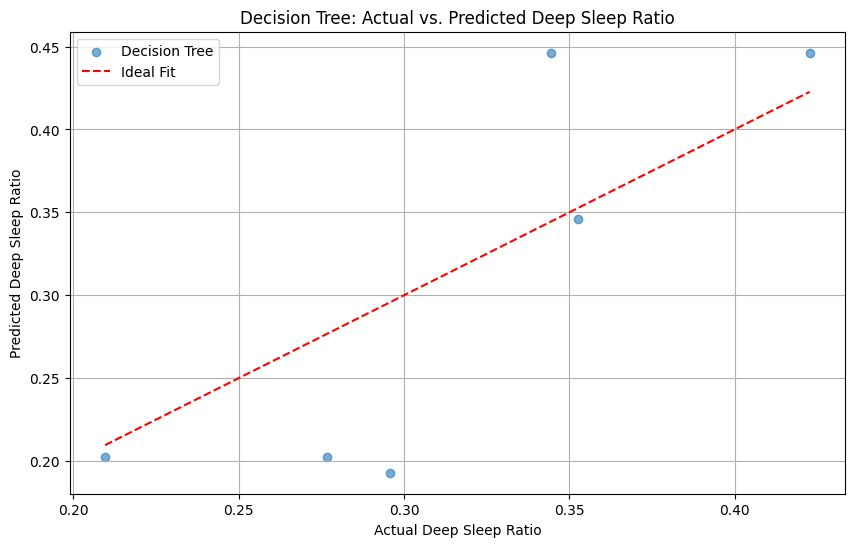

Random Forest Results:
 - Mean Squared Error: 0.00247
 - R² Score: 0.45


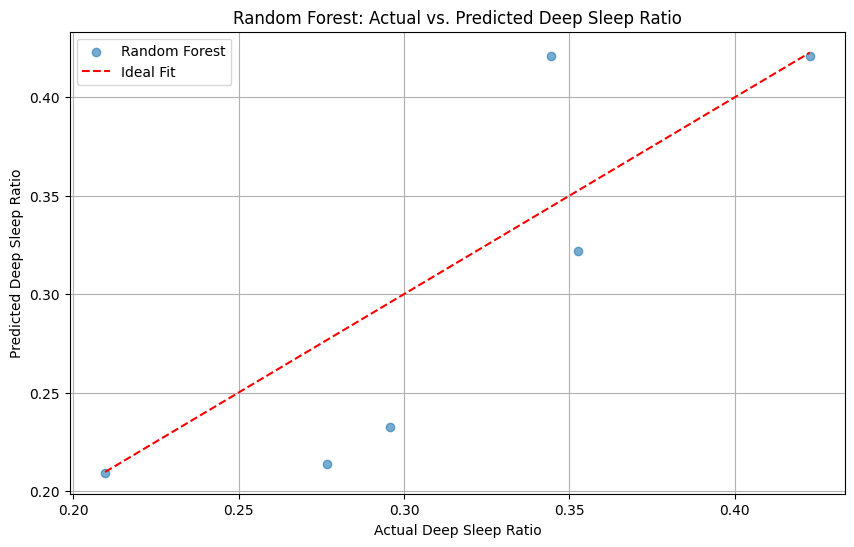

Best Performing Model: Random Forest with R² = 0.45


In [66]:

X = df[['Caffeine (mg)', 'Coffee Consumed Numeric', 'Coffee Period Numeric'] + list(weather_encoded.columns)]
X = X.fillna(X.mean(numeric_only=True))
y = df['Deep Sleep Ratio']

# train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100)
}


results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MSE": mse, "R²": r2}

    print(f"{name} Results:\n - Mean Squared Error: {mse:.5f}\n - R² Score: {r2:.2f}")

    # Scatterplot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.6, label=name)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             color='red', linestyle='--', label="Ideal Fit")
    plt.title(f"{name}: Actual vs. Predicted Deep Sleep Ratio")
    plt.xlabel("Actual Deep Sleep Ratio")
    plt.ylabel("Predicted Deep Sleep Ratio")
    plt.legend()
    plt.grid(True)
    plt.show()

# Best Model
best_model = max(results, key=lambda x: results[x]['R²'])
print(f"Best Performing Model: {best_model} with R² = {results[best_model]['R²']:.2f}")